<a href="https://colab.research.google.com/github/Haythem-Jaidane/BASIRA-Lab_Internship/blob/main/Federated_learning_with_domain_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# I - Install the needed libraries

### MedMNIST : is large dataset collection of medical images. we have a library that enable us to work with.    

In [ ]:
pip install -r ../requirements.txt

# II - Import the ibraries we need in this notebbok

In [1]:
import numpy as np

import pandas as pd

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt

import copy
import os

import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import ToTensor
import torch.nn.functional as F

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn import metrics

from medmnist.dataset import DermaMNIST,BloodMNIST
from medmnist import INFO

In [2]:
import sys
sys.path.insert(0,"..")

from scripts.dataProcessing import DataProcessing
from scripts.Models import *
from scripts.training import Training
from scripts.evaluation import evaluation
from scripts.plot import Results

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# III - data loadding and investigation

## 1 - data processing object definition

In [4]:
dermaDataPreprocessing = DataProcessing(DermaMNIST,device)
bloodDataPreprocessing = DataProcessing(BloodMNIST,device)

Using downloaded and verified file: ../data/dermamnist/raw/dermamnist.npz
Using downloaded and verified file: ../data/dermamnist/raw/dermamnist.npz
Using downloaded and verified file: ../data/bloodmnist/raw/bloodmnist.npz
Using downloaded and verified file: ../data/bloodmnist/raw/bloodmnist.npz


## 2 - data processing and investigation

### DermaMNIST

In [5]:
print(dermaDataPreprocessing)

dataset name : dermamnist
Train Dataset description
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: ../data/dermamnist/raw/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY 4.0
Test Dataset description
D

D:\programme\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


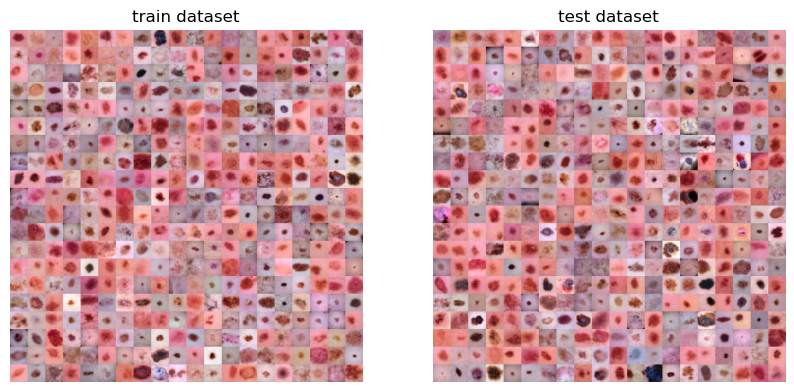

In [6]:
dermaDataPreprocessing.viewDataset(True,"datasetView")

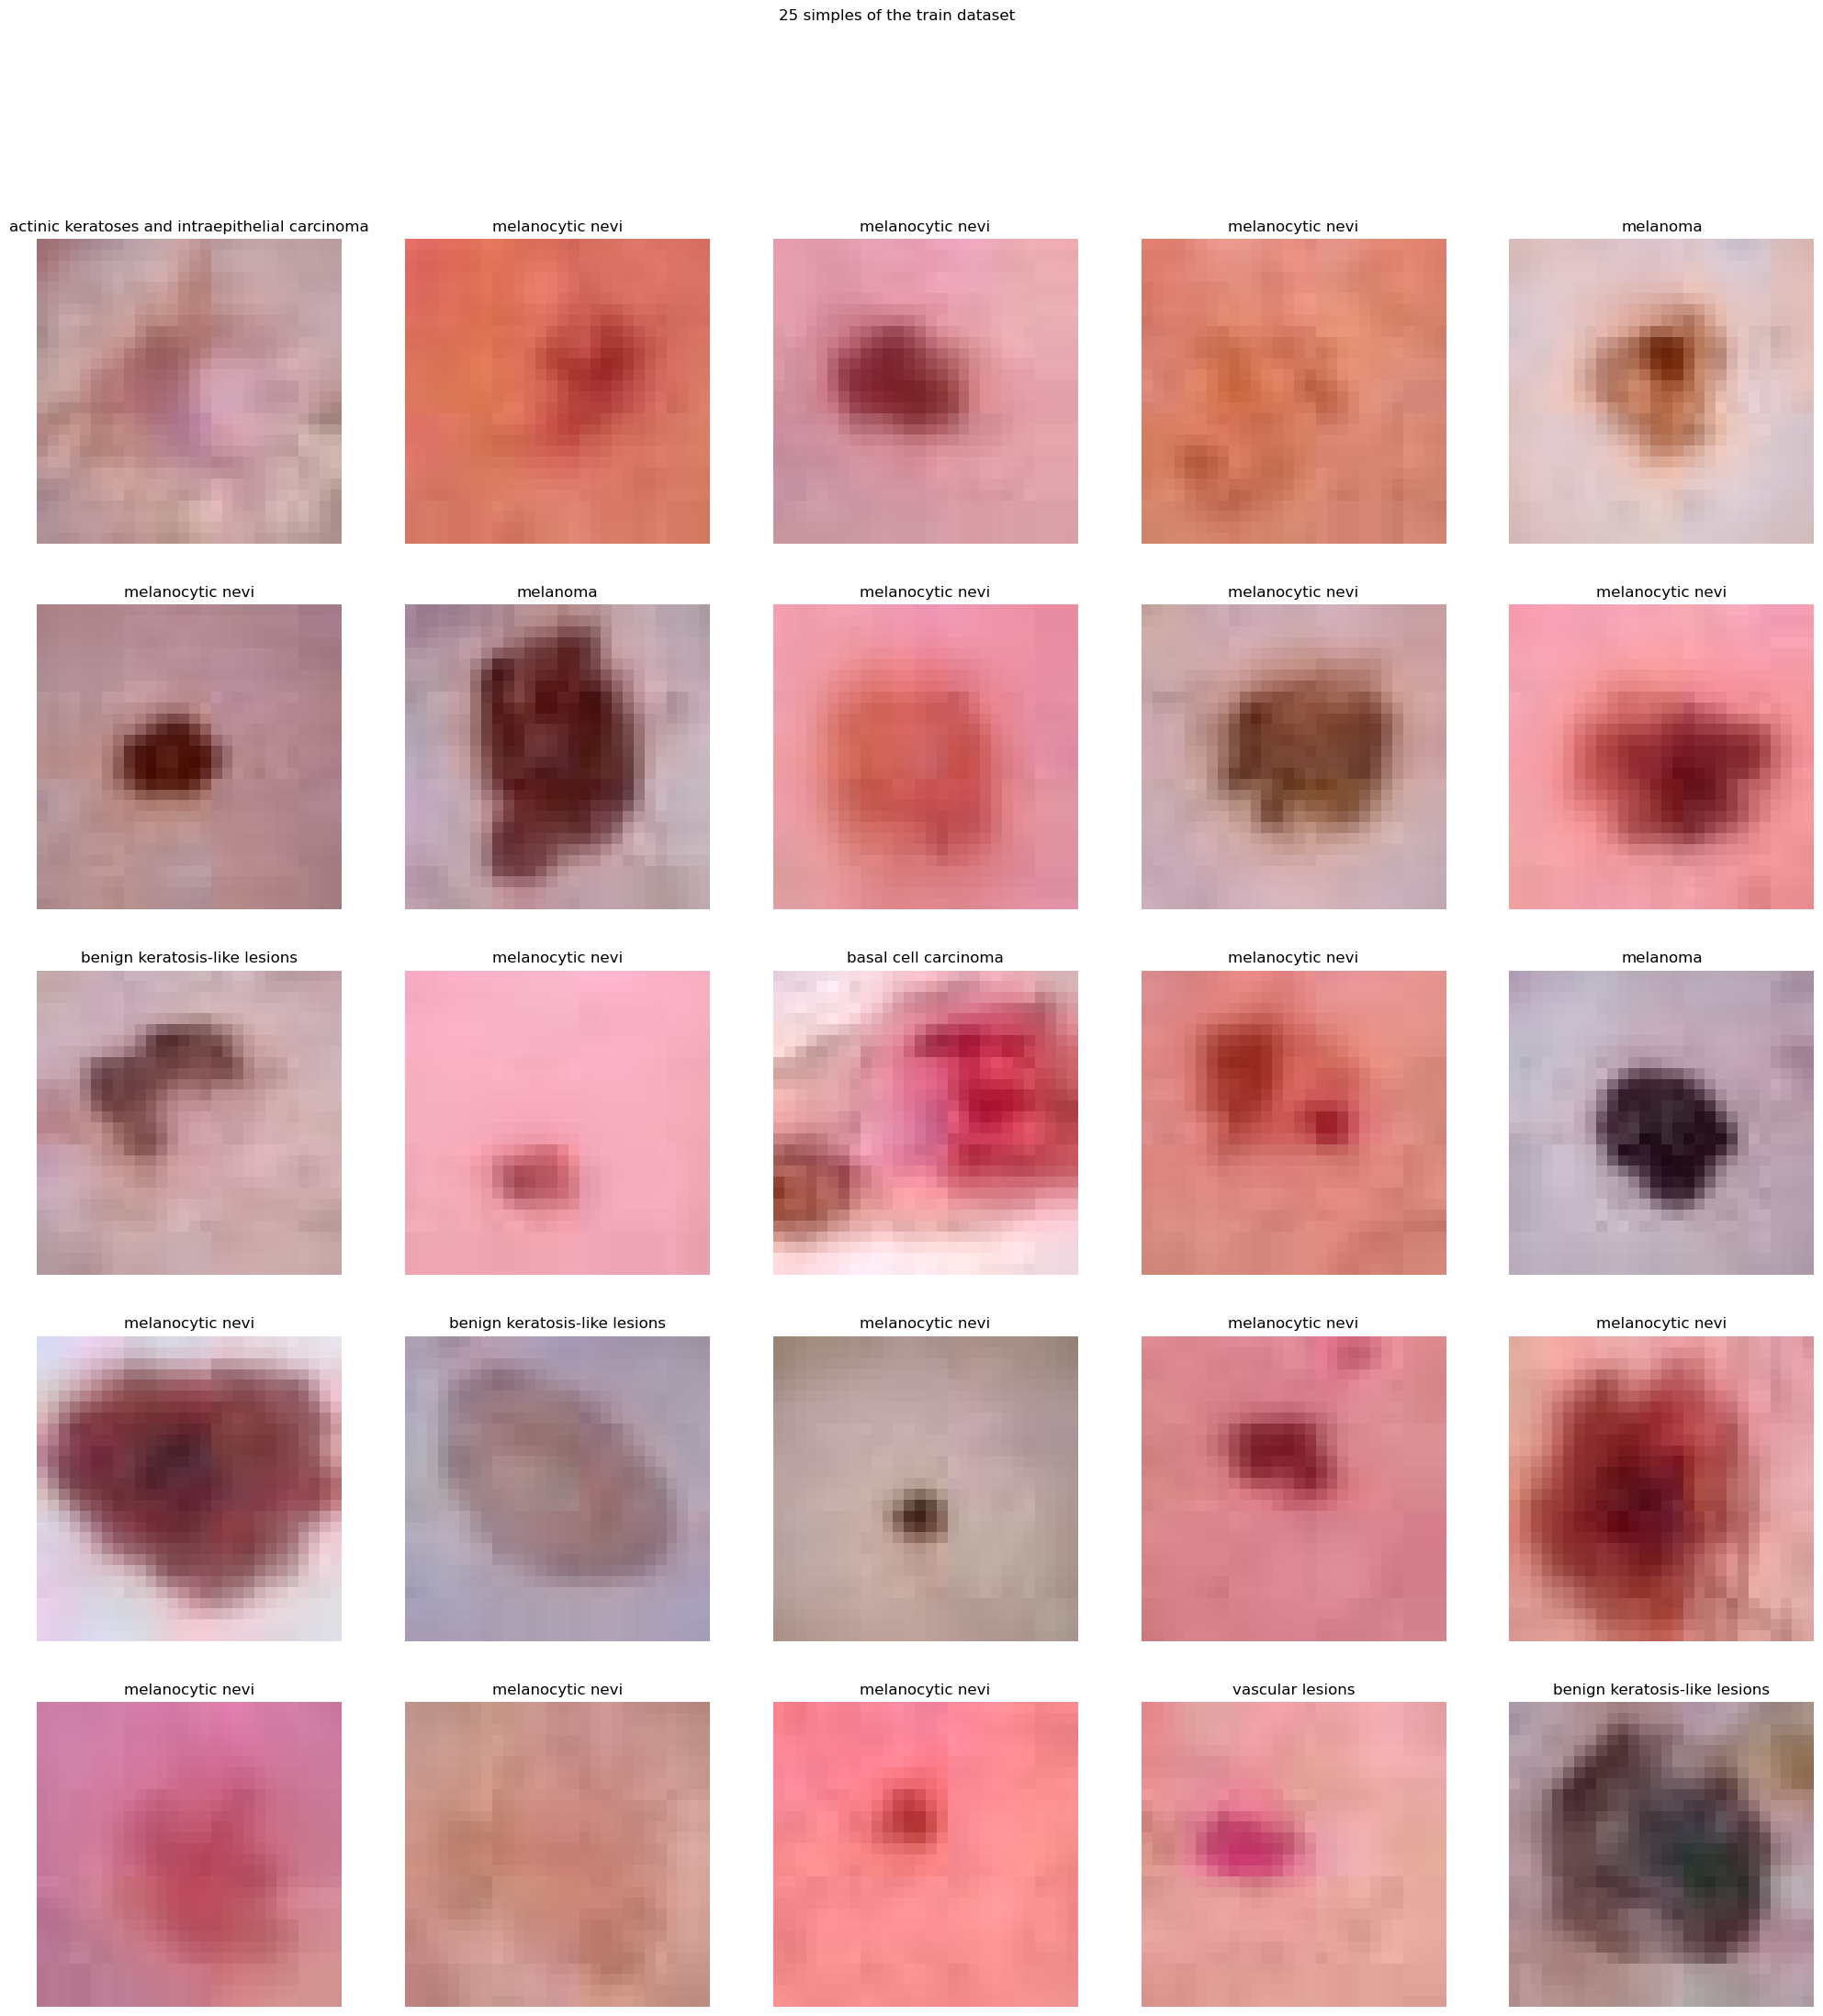

In [7]:
dermaDataPreprocessing.viewNSimple(25,5,5,"original",True,"viewSimples")

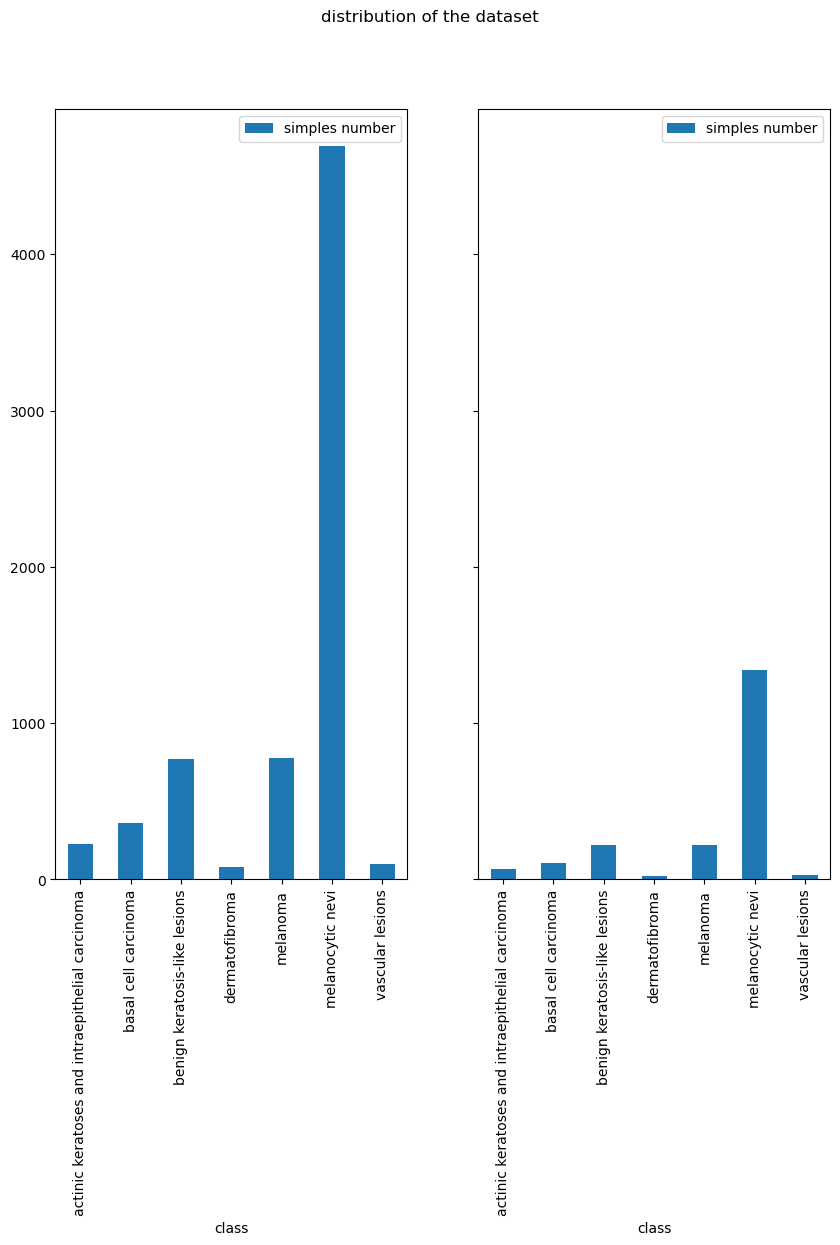

In [8]:
dermaDataPreprocessing.plotLabelsDistribution("original",True,"labeldistribution")

In [9]:
dermaDataPreprocessing.cleanImblanceData("original","clean")

In [10]:
len(dermaDataPreprocessing)

you have 2 dataset


2

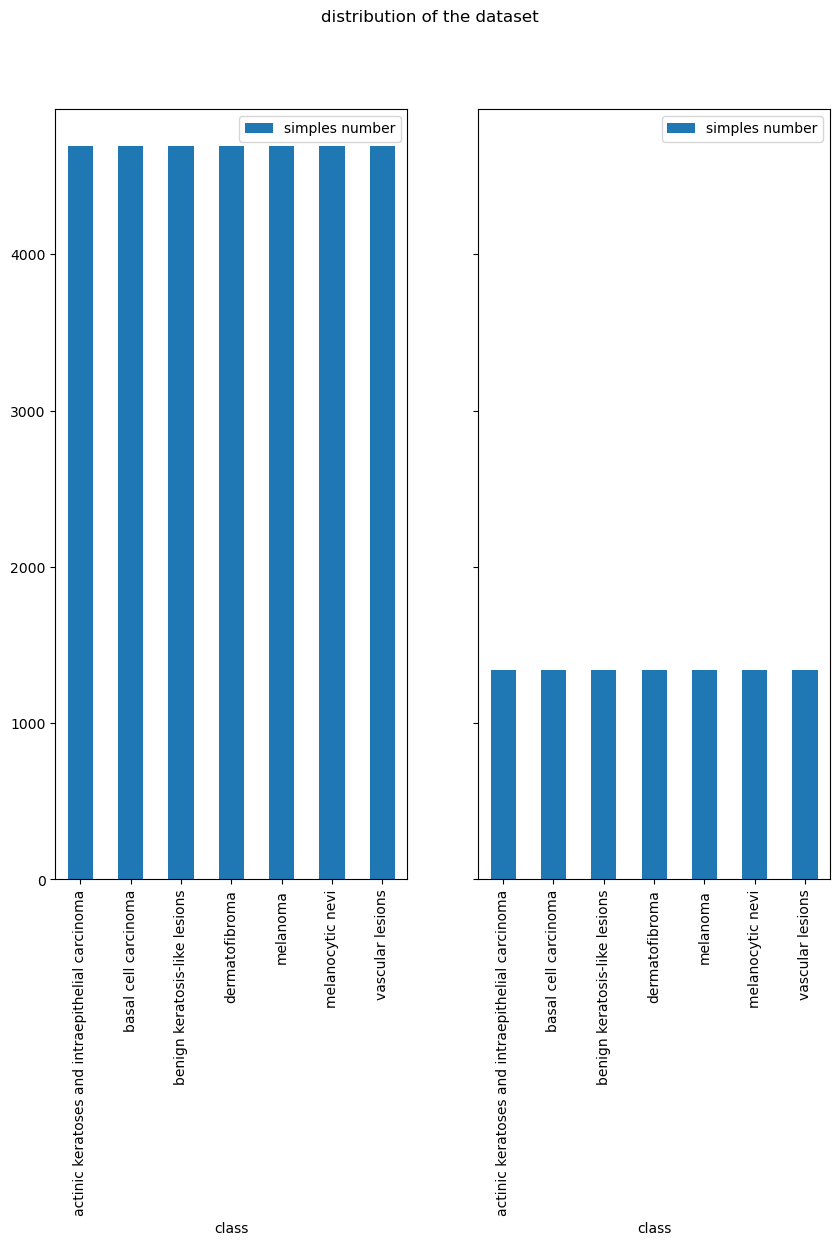

In [11]:
dermaDataPreprocessing.plotLabelsDistribution("clean",True,"labeldistribution")

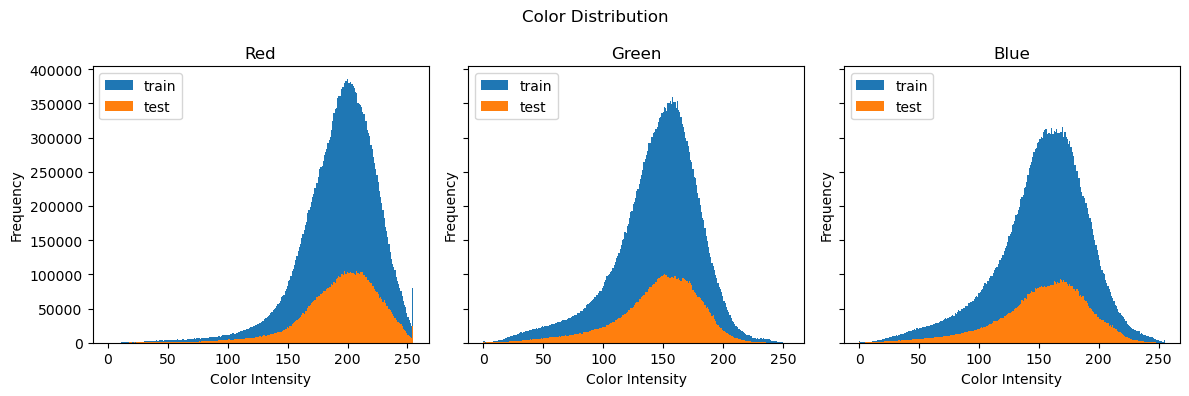

In [12]:
dermaDataPreprocessing.plotColorDistribution('clean',True,"colorDistribution")

In [13]:
dermaDataPreprocessing.makeDomainshift("clean",[0.5,0.5,0.5],"shift")

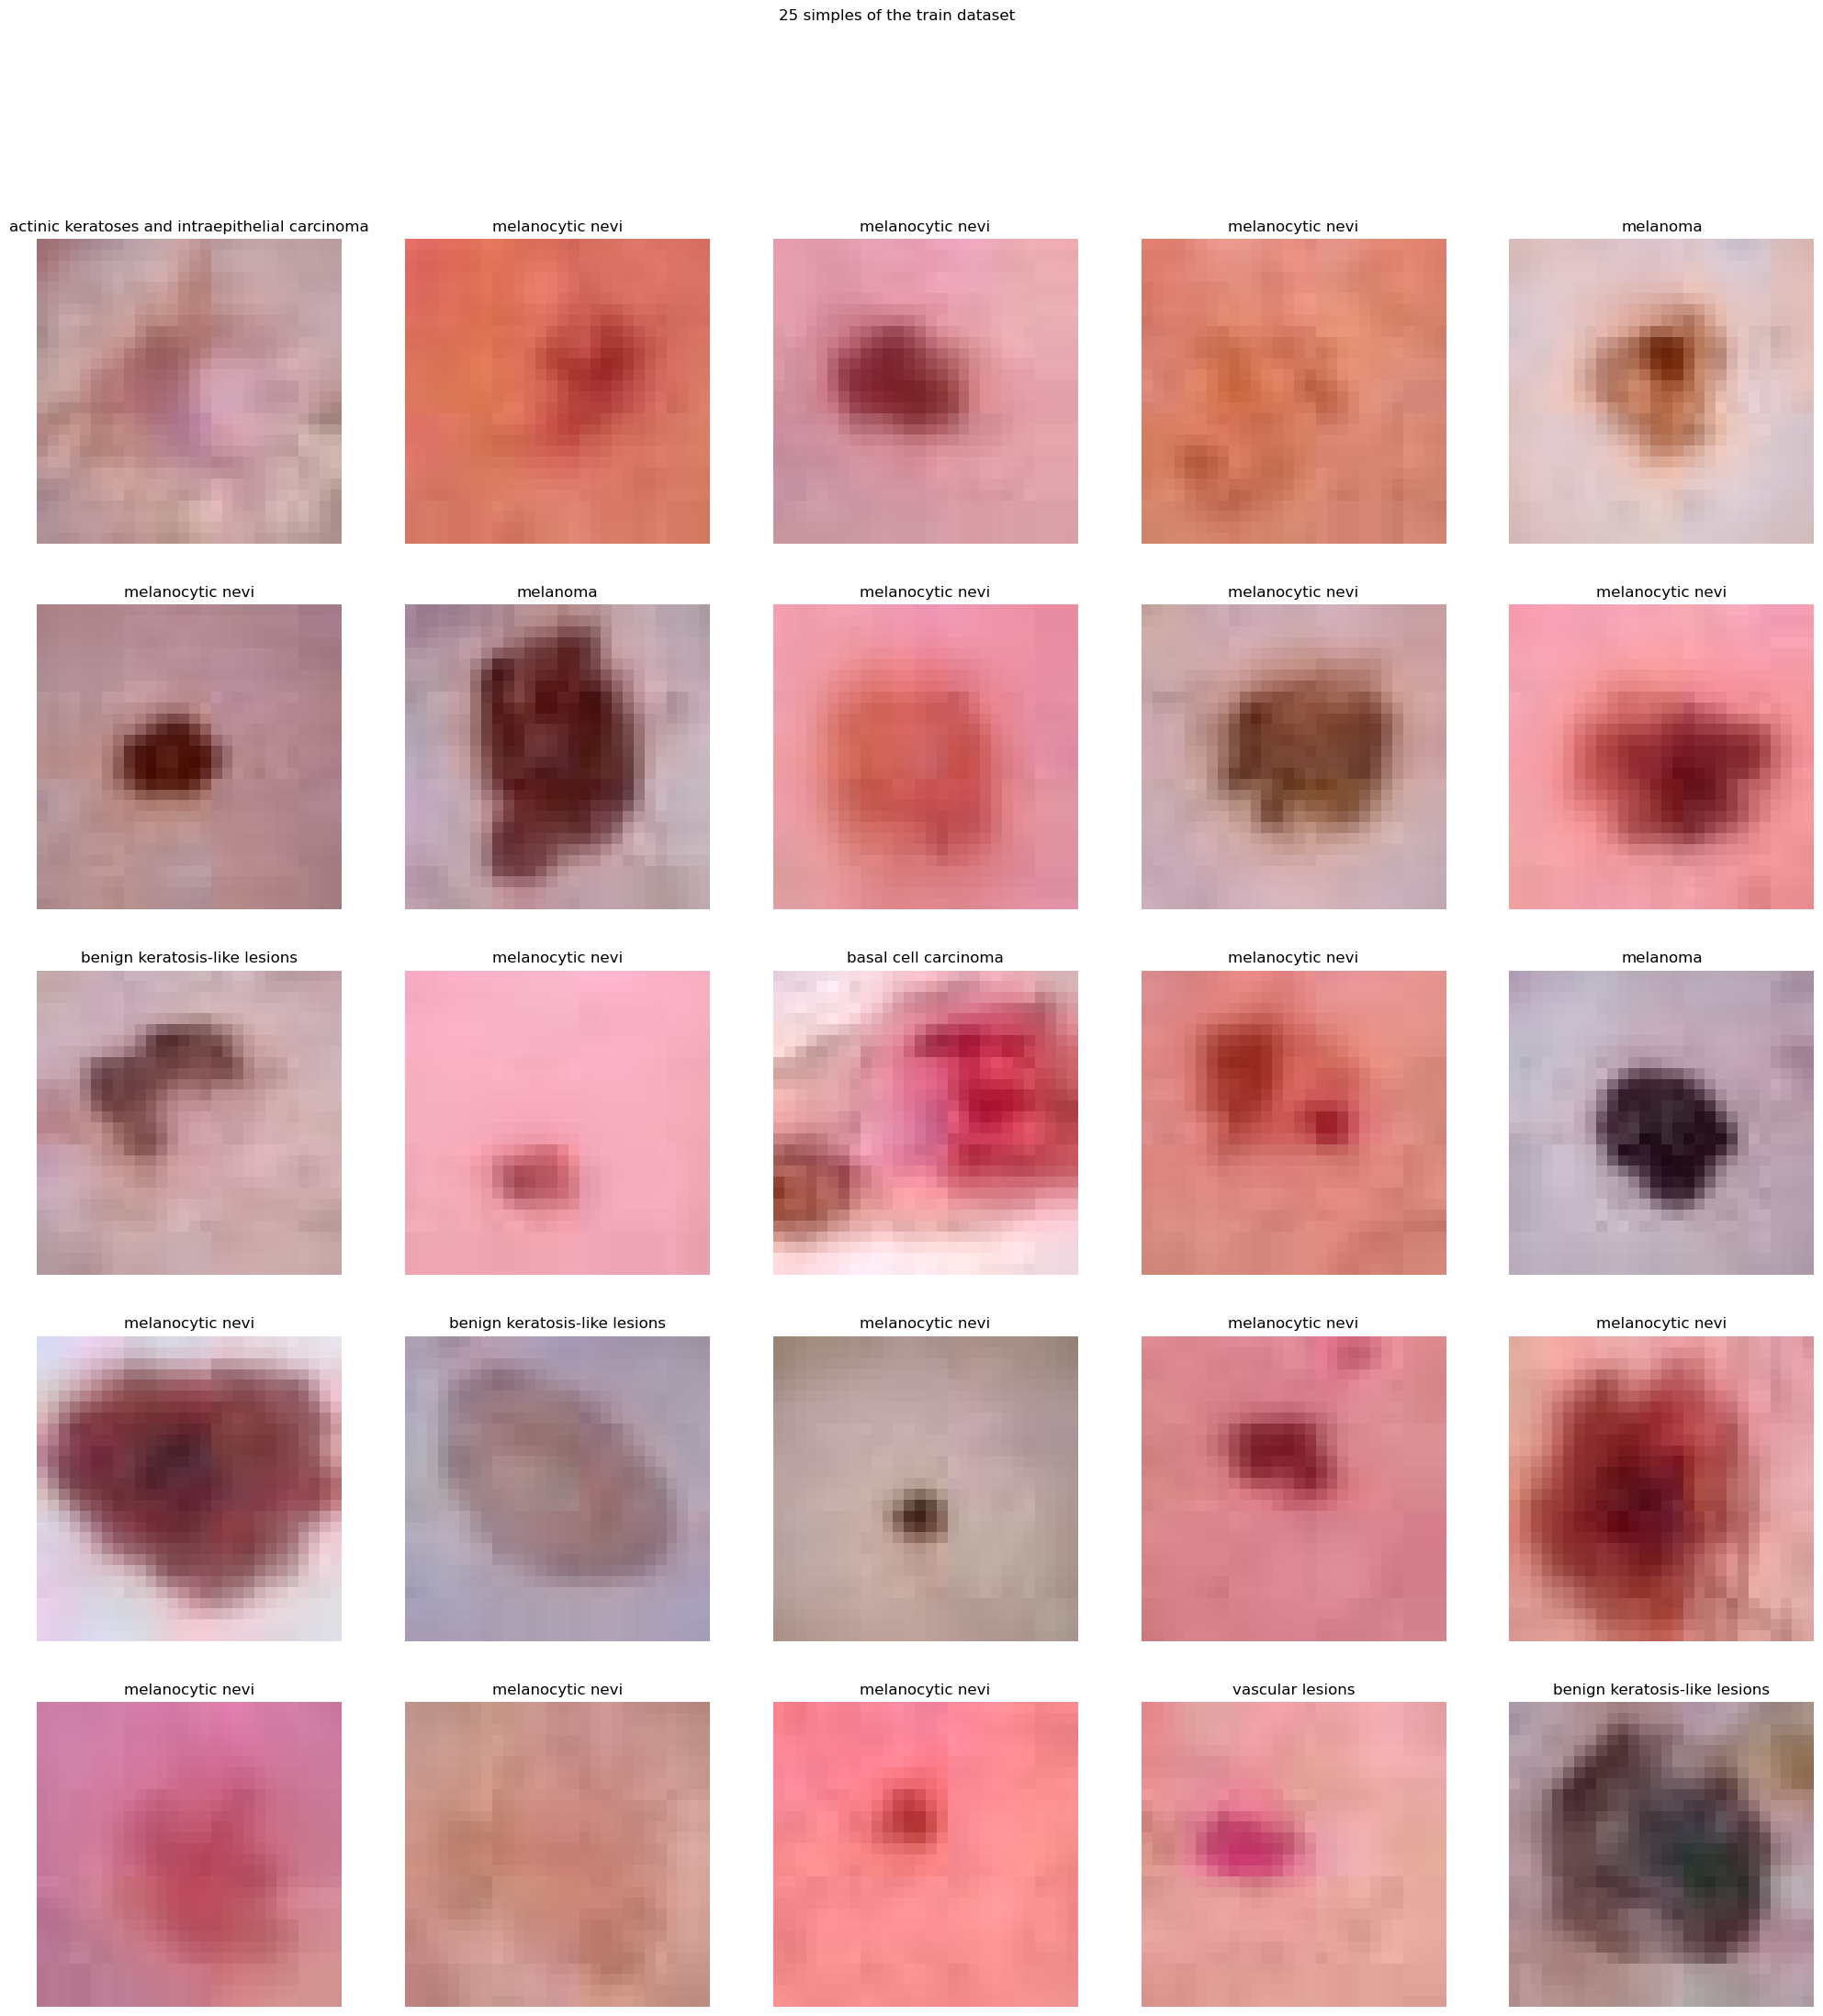

In [14]:
dermaDataPreprocessing.viewNSimple(25,5,5,"shift",True,"viewSimples")

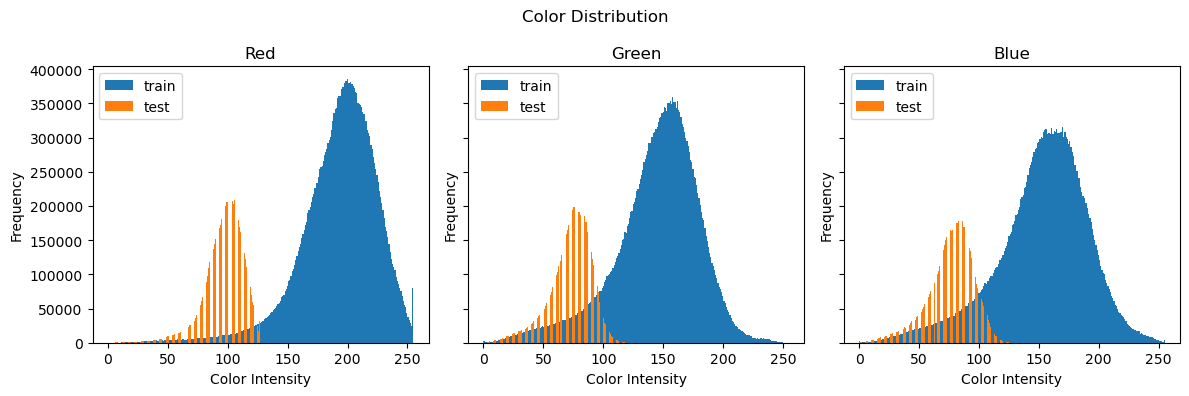

In [15]:
dermaDataPreprocessing.plotColorDistribution('shift',True,"colorDistribution")

In [16]:
len(dermaDataPreprocessing)

you have 3 dataset


3

In [17]:
dermaDataPreprocessing.save_dataset()

### BloodMNIST

In [18]:
print(bloodDataPreprocessing)

dataset name : bloodmnist
Train Dataset description
Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: ../data/bloodmnist/raw/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200,

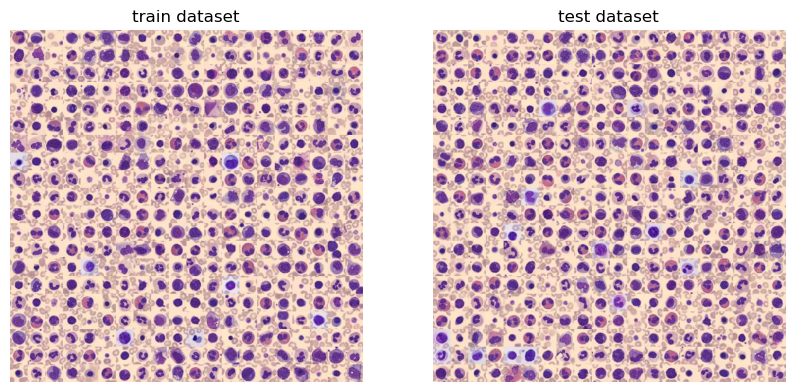

In [19]:
bloodDataPreprocessing.viewDataset(True,"datasetView")

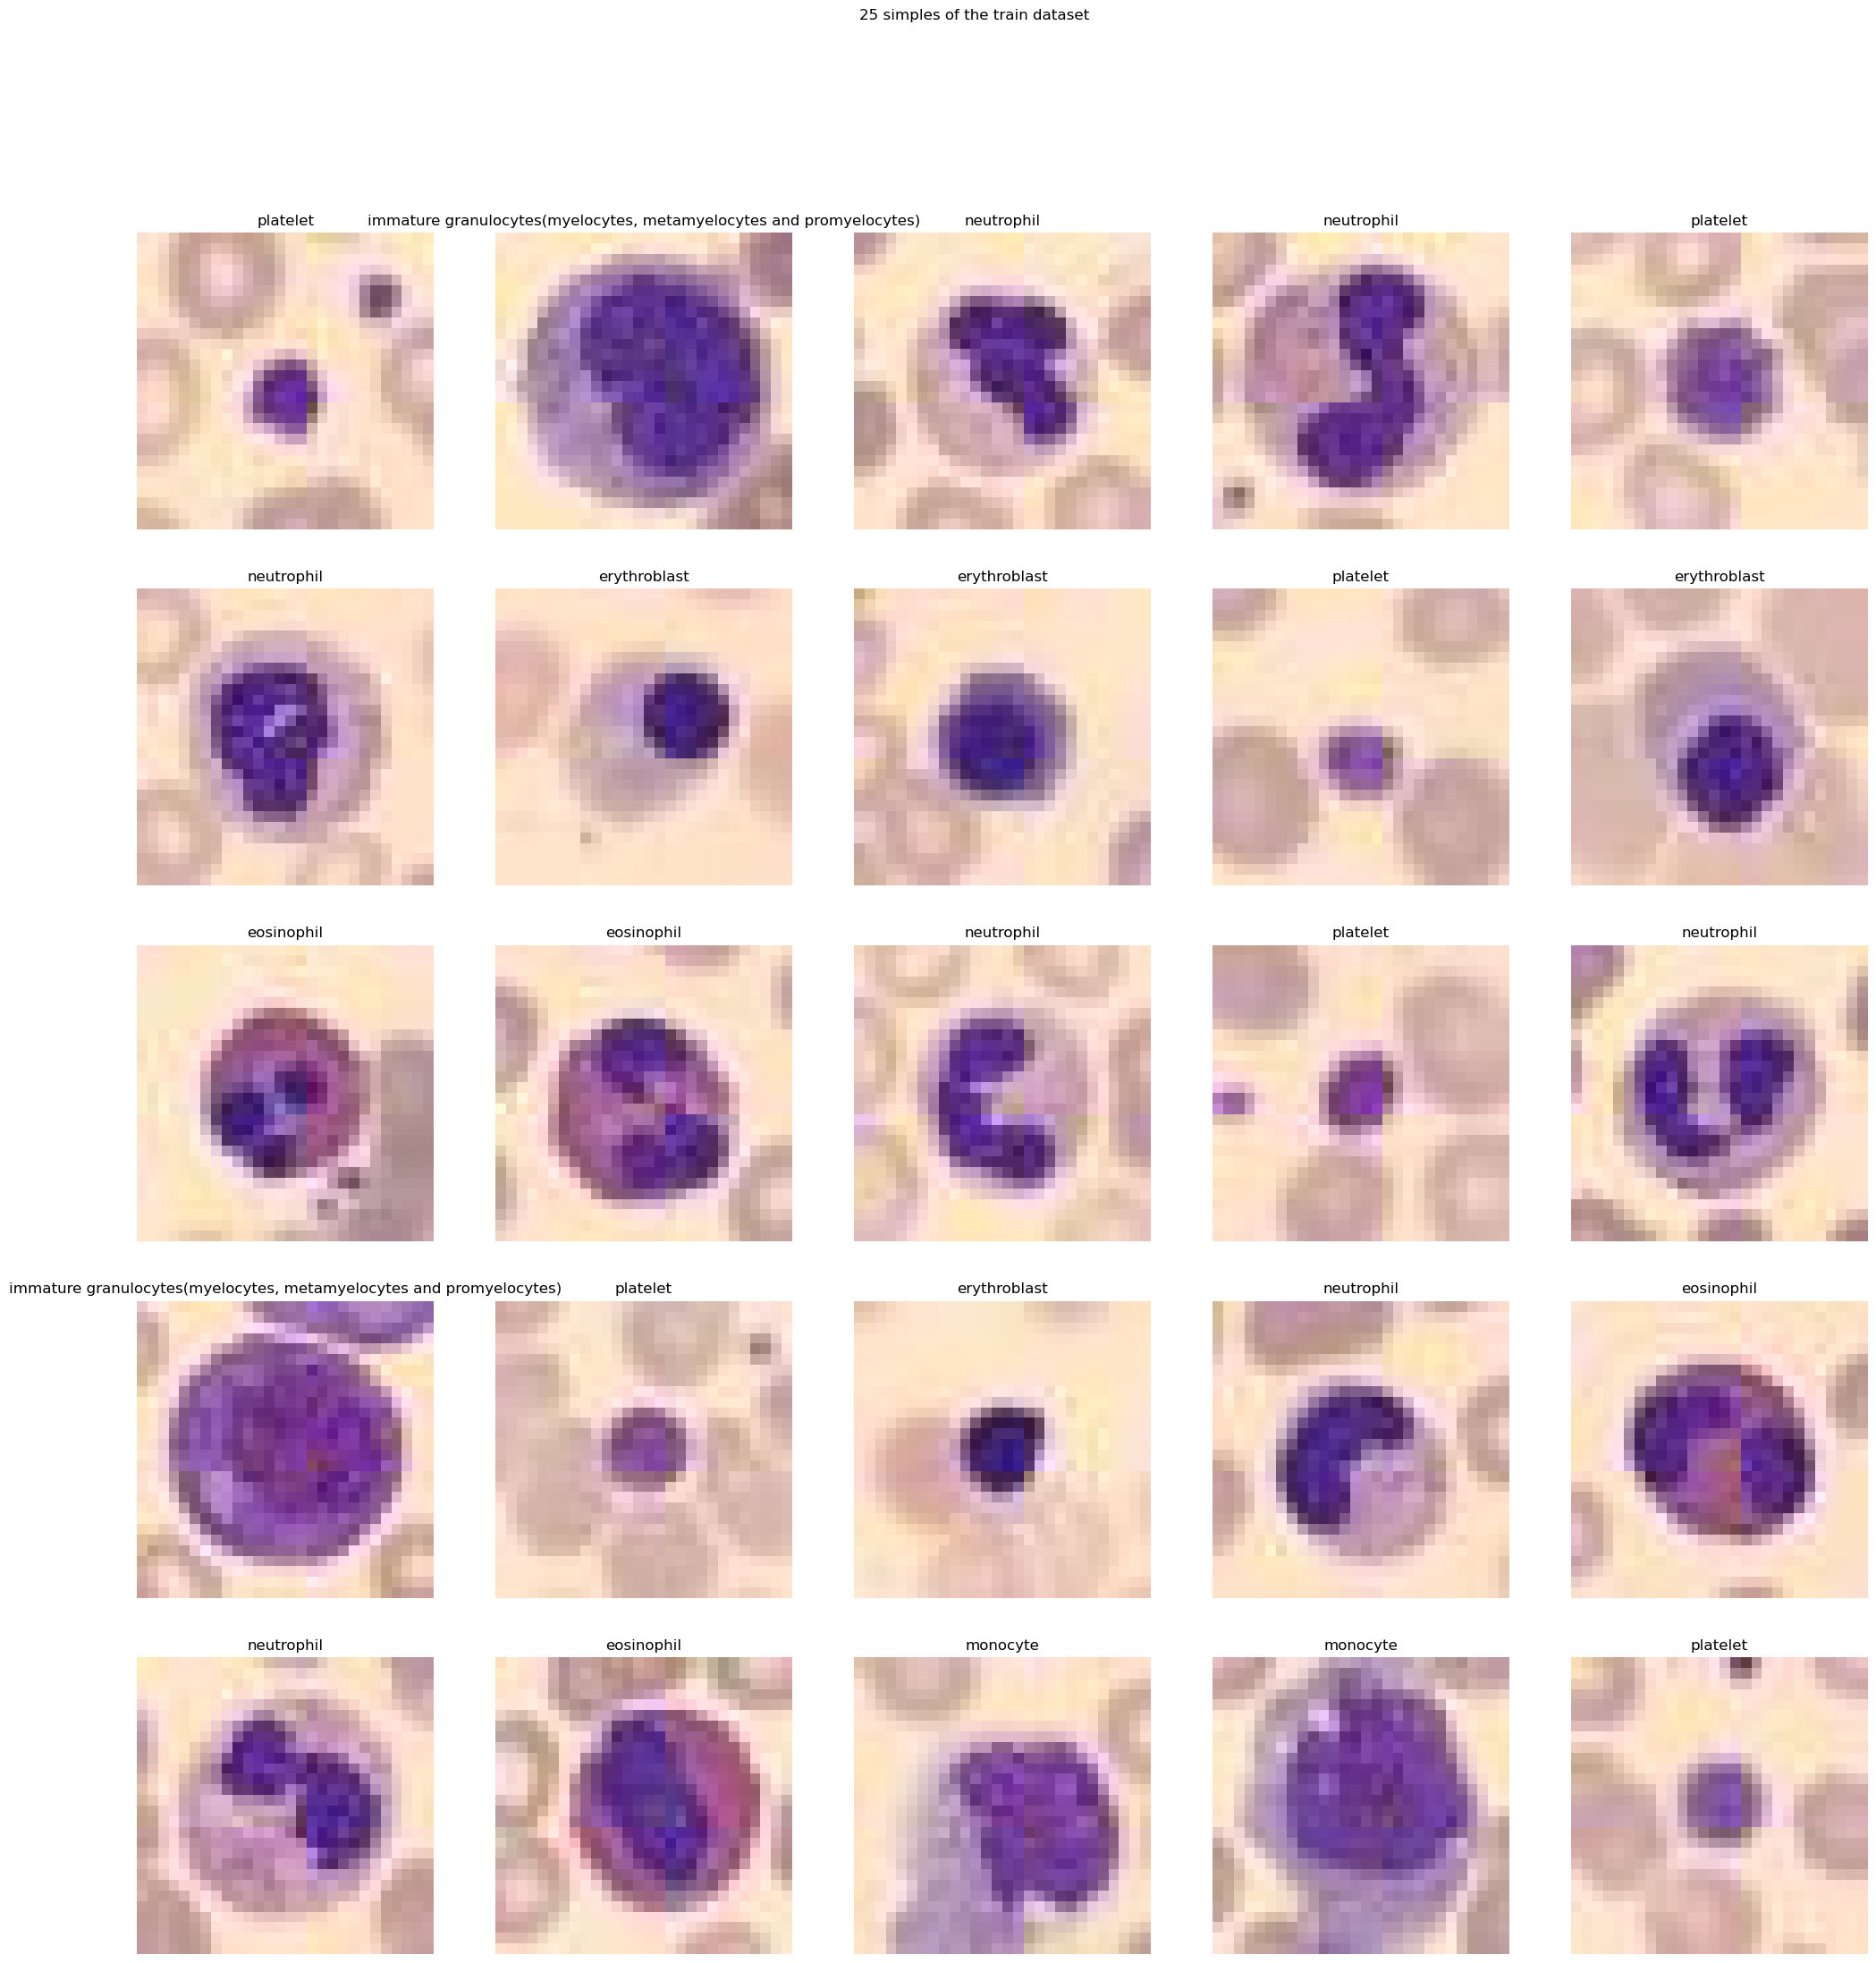

In [20]:
bloodDataPreprocessing.viewNSimple(25,5,5,"original",True,"viewSimples")

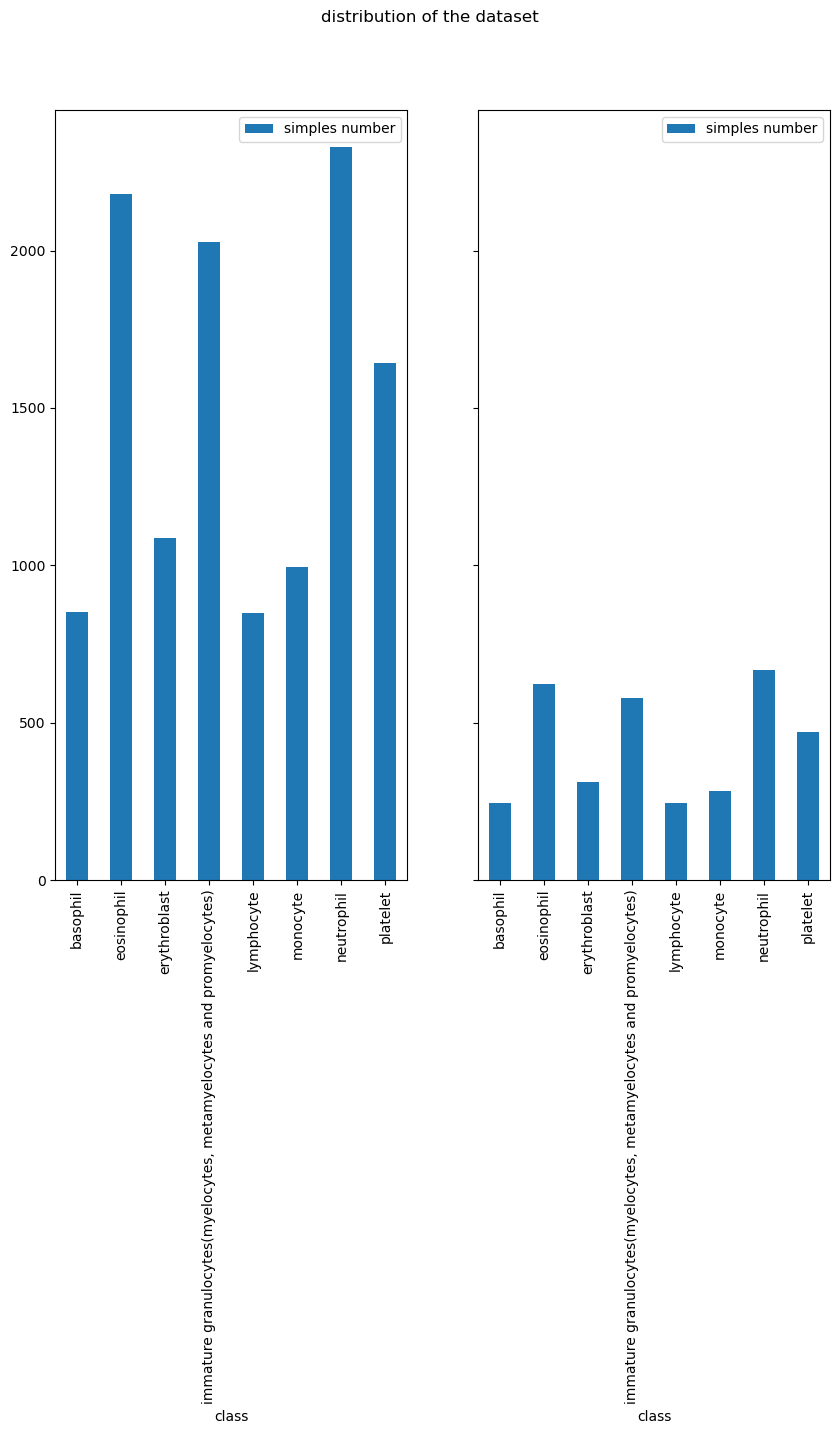

In [21]:
bloodDataPreprocessing.plotLabelsDistribution("original",True,"labeldistribution")

In [22]:
bloodDataPreprocessing.cleanImblanceData("original","clean")

In [23]:
len(bloodDataPreprocessing)

you have 2 dataset


2

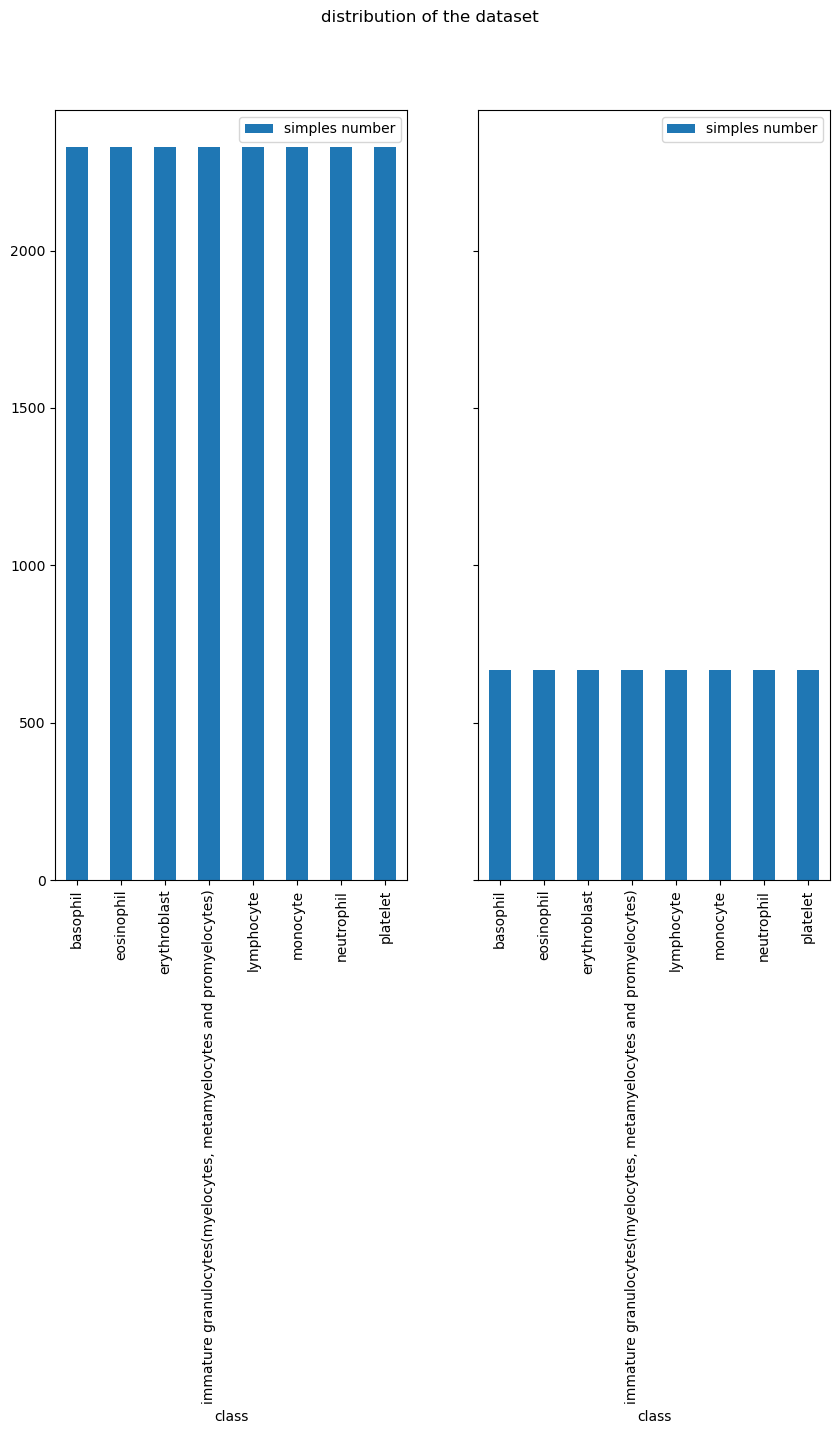

In [24]:
bloodDataPreprocessing.plotLabelsDistribution("clean",True,"labeldistribution")

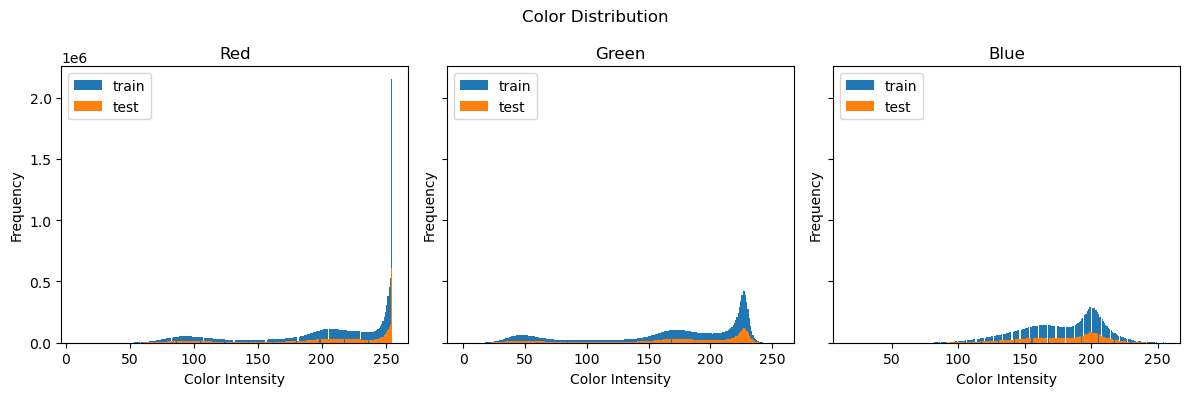

In [25]:
bloodDataPreprocessing.plotColorDistribution('clean',True,"colorDistribution")

In [26]:
bloodDataPreprocessing.makeDomainshift("clean",[0.5,0.5,0.5],"shift")

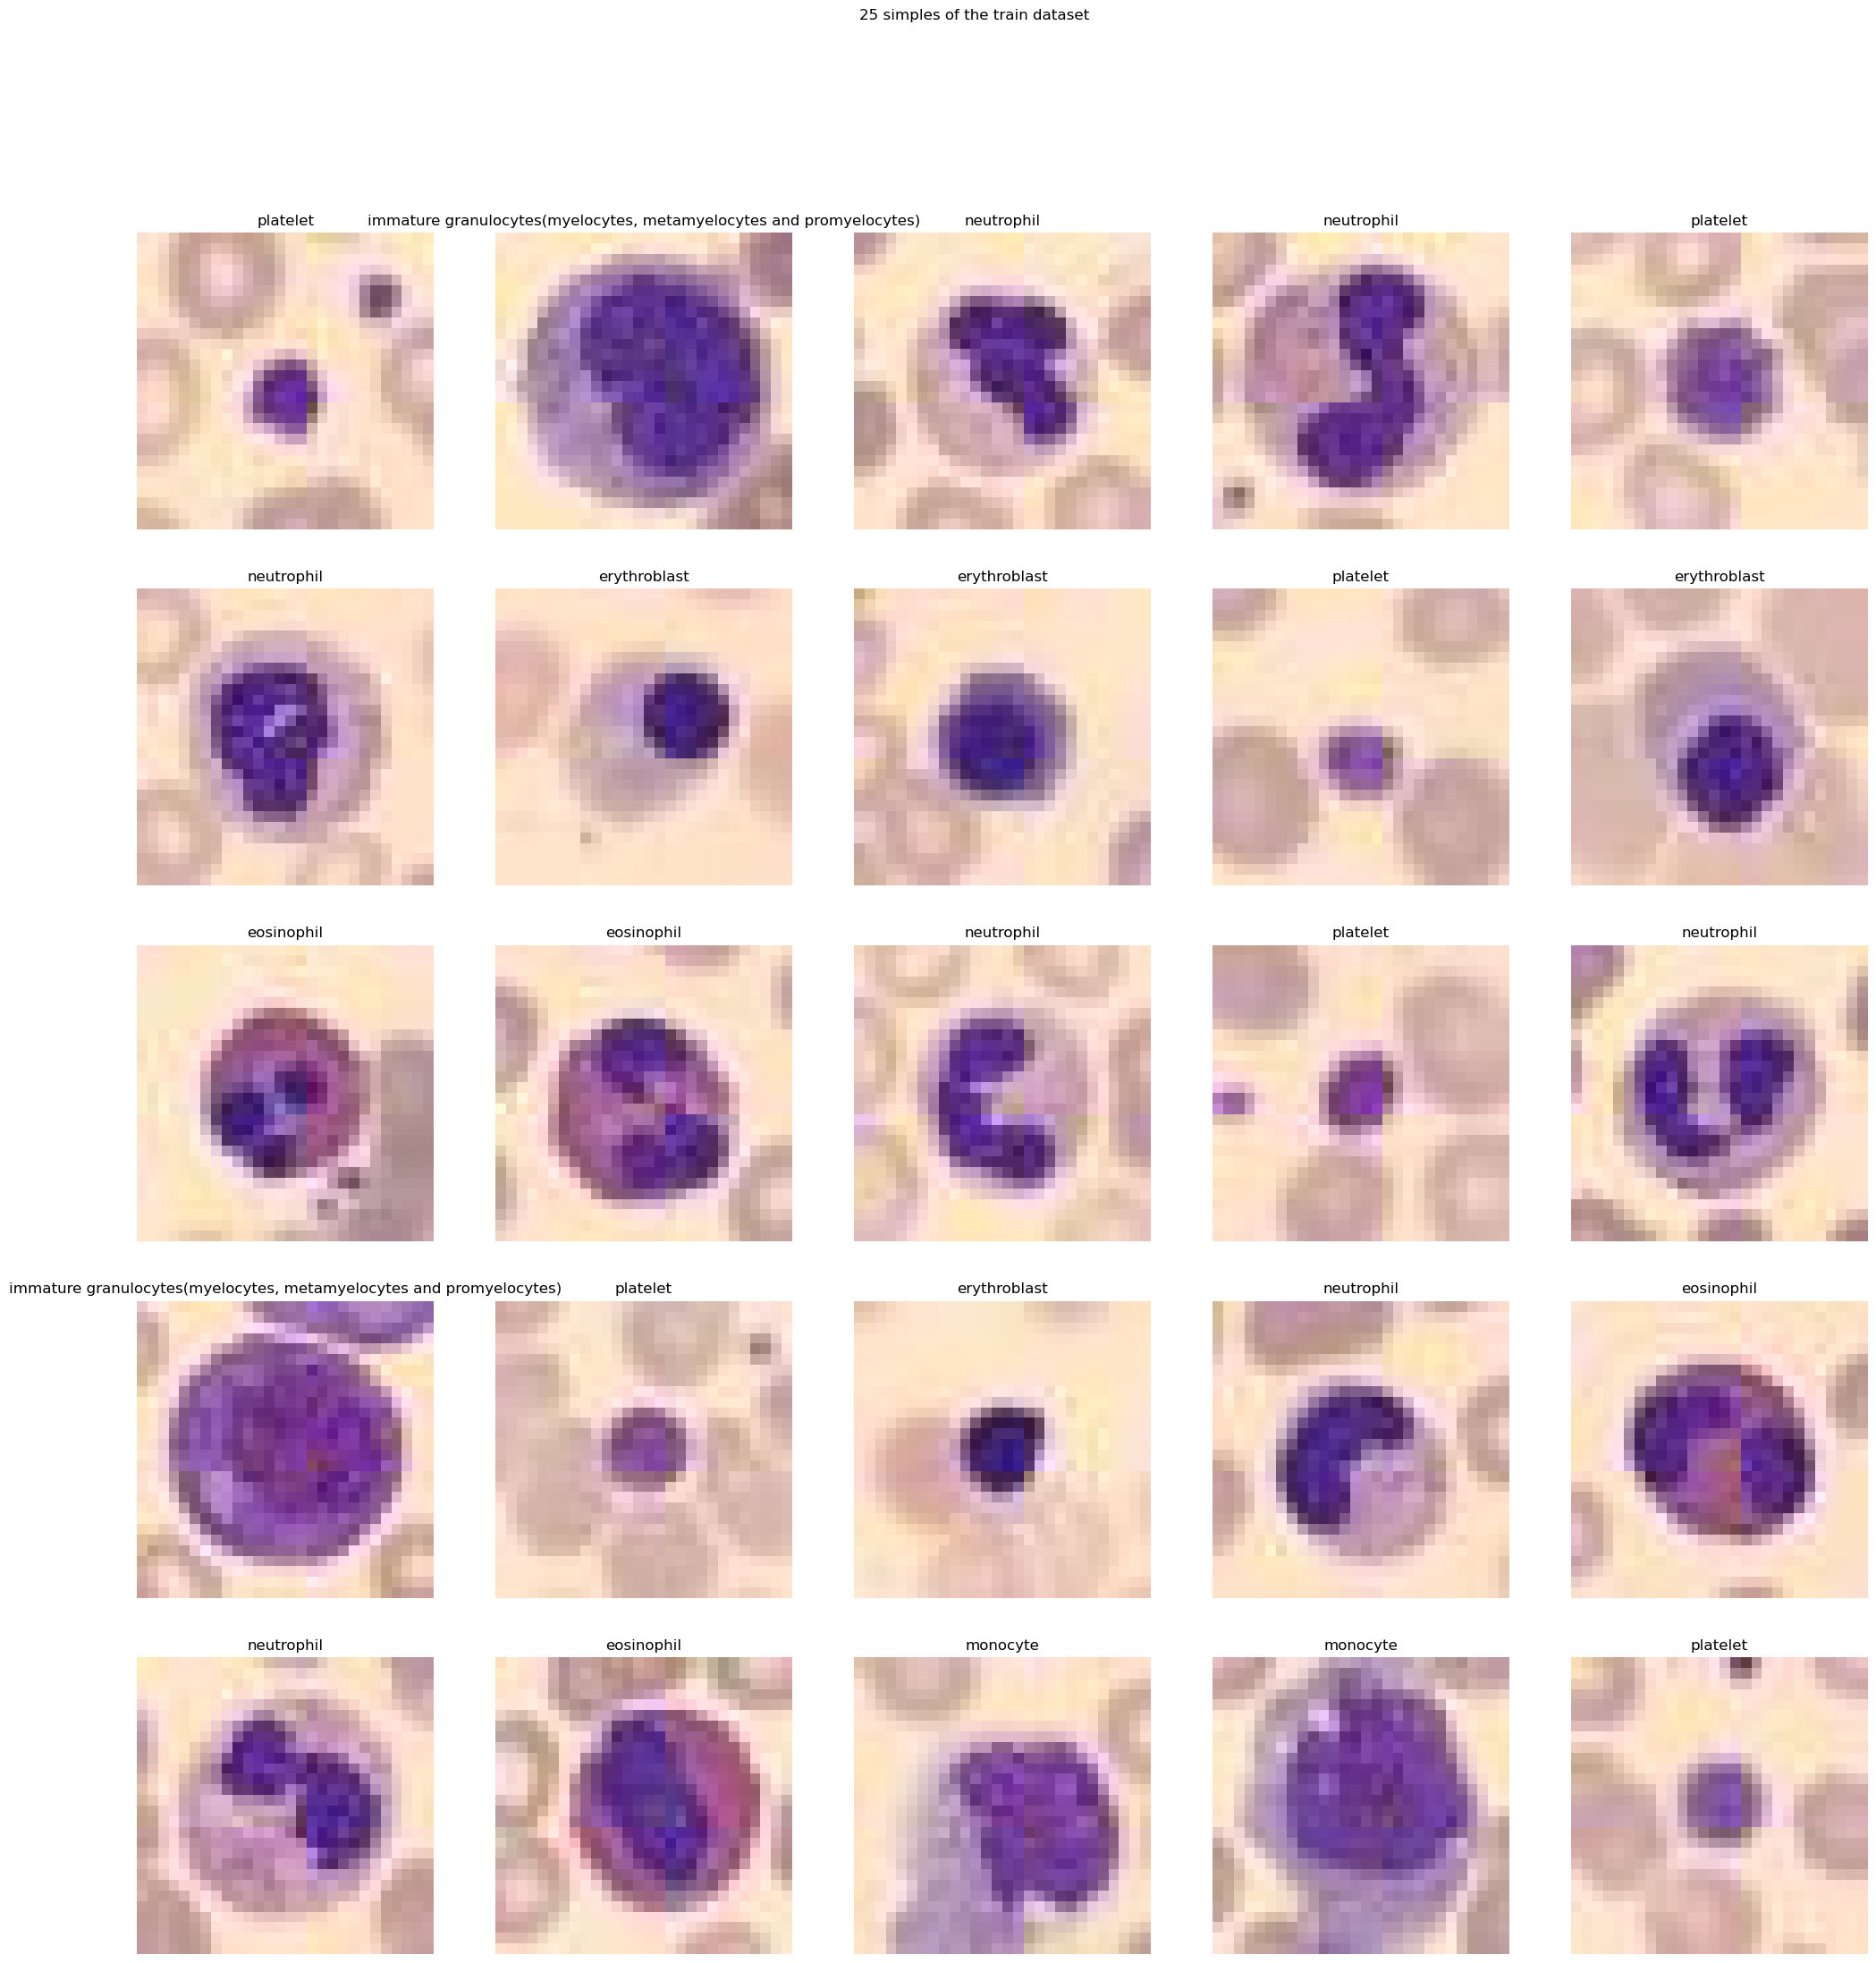

In [27]:
bloodDataPreprocessing.viewNSimple(25,5,5,"shift",True,"viewSimples")

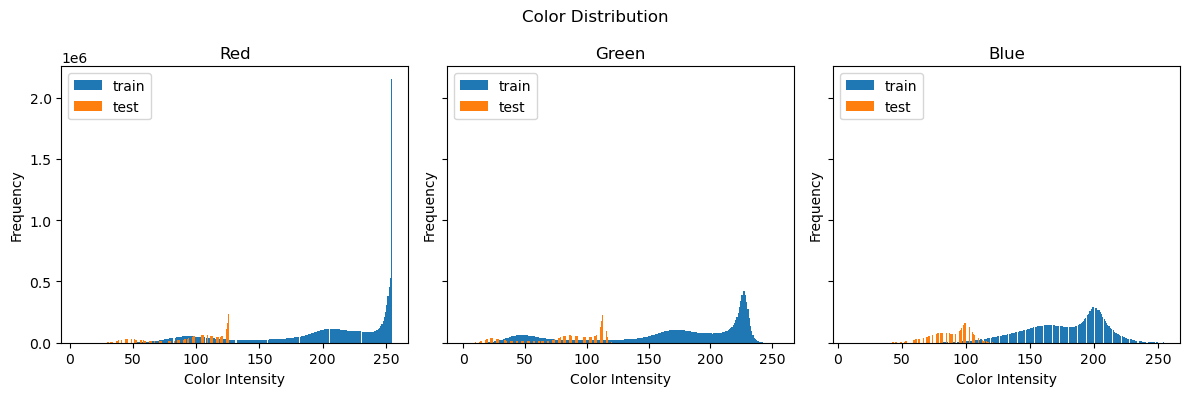

In [28]:
bloodDataPreprocessing.plotColorDistribution('shift',True,"colorDistribution")

In [29]:
len(bloodDataPreprocessing)

you have 3 dataset


3

In [30]:
bloodDataPreprocessing.save_dataset()

# IV - Model definition

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, gen_hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, gen_hidden_dim),
            nn.ReLU(),
            nn.Linear(gen_hidden_dim, gen_hidden_dim),
            nn.ReLU(),
            nn.Linear(gen_hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        x = self.model(x) 
        x = (x * 255).clamp(0, 255)
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim, disc_hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + label_dim, disc_hidden_dim),
            nn.ReLU(),
            nn.Linear(disc_hidden_dim, disc_hidden_dim),
            nn.ReLU(),
            nn.Linear(disc_hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input, labels):
        x = torch.cat([input, labels], dim=1)
        x = self.model(x)
        return x

# Hyperparameters
noise_dim = 5
label_dim = 7
gen_hidden_dim = 300
disc_hidden_dim = 300
output_dim = 28 * 28 * 3
batch_size = 32
num_epochs = 100
learning_rate = 0.00000005
# Load MNIST dataset

X_train, y_train = torch.tensor(dermaDataPreprocessing.dataset["clean"]["train"]["image"]).float().to(device), torch.tensor(dermaDataPreprocessing.dataset["clean"]["train"]["labels"]).long().to(device)

train_dataset = data.TensorDataset(X_train, y_train)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Initialize generator and discriminator
generator = Generator(noise_dim, label_dim, gen_hidden_dim, output_dim)
generator.to(device)
discriminator = Discriminator(output_dim, label_dim, disc_hidden_dim)
discriminator.to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for real_images, real_labels in train_loader:
        # Discriminator training
        real_images=real_images.to(device)
        real_labels=real_labels.to(device)

        optimizer_d.zero_grad()
        real_images = real_images.view(-1, output_dim)


        real_labels_onehot = torch.zeros(real_labels.shape[0], label_dim).to(device).scatter_(1, real_labels.view(-1, 1).long(), 1)
        real_labels_onehot = real_labels_onehot.to(device)

        real_scores = discriminator(real_images, real_labels_onehot)
        real_targets = torch.ones_like(real_scores)
        real_loss = criterion(real_scores, real_targets)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_labels = torch.randint(0, label_dim, (batch_size,))
        fake_labels_onehot = torch.zeros(batch_size, label_dim).scatter_(1, fake_labels.view(-1, 1), 1)
        fake_labels_onehot = fake_labels_onehot.to(device)
        fake_images = generator(noise, fake_labels_onehot)
        fake_scores = discriminator(fake_images, fake_labels_onehot)
        fake_targets = torch.zeros_like(fake_scores).to(device)
        fake_loss = criterion(fake_scores, fake_targets)


        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Generator training
        optimizer_g.zero_grad()
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise, fake_labels_onehot)
        fake_scores = discriminator(fake_images, fake_labels_onehot)
        g_targets = torch.ones_like(fake_scores)
        g_loss = criterion(fake_scores, g_targets)
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Generate and visualize samples


    num_samples = 10
    noise = torch.randn(num_samples, noise_dim).to(device)
    sample_labels = torch.arange(1, num_samples) % label_dim
    sample_labels_onehot = torch.ones(num_samples, label_dim).scatter_(1, sample_labels.view(-1, 1), 1)
    sample_labels_onehot = sample_labels_onehot.to(device)
    generated_samples = generator(noise, sample_labels_onehot).view(-1,3, 28, 28).permute(0,2,3,1).detach().to("cpu").numpy().astype(np.uint8)
    print(generated_samples.shape)

    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(generated_samples[i])
        plt.axis('off')
    plt.show()


# V - training Models

## 1 - object definition

In [ ]:
hyperparameter_CNN = {
    "epoch_num":5,
    "epoch_in_round": 1,
    "num_periode":5,
    "lr":1e-3,
    "batch_size":128
}

hyperparameter_ResNet18 = {
    "epoch_num":10,
    "epoch_in_round": 1,
    "num_periode":5,
    "lr":1e-6,
    "batch_size":32
}

CNN_normal = Training(num_fold=3,ModelType=CNN,Data=dermaDataPreprocessing,optimizer=optim.SGD,type_data="clean",hyperparameter=hyperparameter_CNN,algos=["baseline","base","FedAVG"])
ResNet18_normal = Training(num_fold=3, ModelType=ResNet18,Data=dermaDataPreprocessing,optimizer=optim.Adam,type_data="clean",hyperparameter=hyperparameter_ResNet18,algos=["baseline","base","FedAVG"])
ResNet18_pretrainied_normal = Training(num_fold=3, ModelType=ResNet18_pretrainied,Data=dermaDataPreprocessing,optimizer=optim.Adam,type_data="clean",hyperparameter=hyperparameter_ResNet18,algos=["baseline","base","FedAVG"])

CNN_shift = Training(num_fold=3,ModelType=CNN,Data=dermaDataPreprocessing,optimizer=optim.SGD,type_data="shift",hyperparameter=hyperparameter_CNN,algos=["baseline","base","FedAVG"])
ResNet18_shift = Training(num_fold=3, ModelType=ResNet18,Data=dermaDataPreprocessing,optimizer=optim.Adam,type_data="shift",hyperparameter=hyperparameter_ResNet18,algos=["baseline","base","FedAVG"])
ResNet18_pretrainied_shift = Training(num_fold=3, ModelType=ResNet18_pretrainied,Data=dermaDataPreprocessing,optimizer=optim.Adam,type_data="shift",hyperparameter=hyperparameter_ResNet18,algos=["baseline","base","FedAVG"])

print("==============================")
print("        DermaMNIST            ")
print("==============================")
print()
print("==============================")
print("        Normal                ")
print("==============================")
print()

CNN_normal.trainPipline()
#ResNet18_normal.trainPipline()
#ResNet18_pretrainied_normal.trainPipline()

print("==============================")
print("        shift                 ")
print("==============================")

CNN_shift.trainPipline()
#ResNet18_shift.trainPipline()
#ResNet18_pretrainied_shift.trainPipline()

        DermaMNIST            

        Normal                

baseline
Fold 1:
Epoch 1:
Train Loss: 1.9169
Train Accuracy: 19.99%
Validation Loss: 1.8940
Validation Accuracy: 25.51%

time spend : 204 s

Epoch 2:
Train Loss: 1.8687
Train Accuracy: 27.29%
Validation Loss: 1.8408
Validation Accuracy: 31.97%

time spend : 51 s

Epoch 3:
Train Loss: 1.8080
Train Accuracy: 33.74%
Validation Loss: 1.7736
Validation Accuracy: 37.42%

time spend : 53 s

Epoch 4:
Train Loss: 1.7345
Train Accuracy: 38.13%
Validation Loss: 1.6937
Validation Accuracy: 38.61%

time spend : 56 s

Epoch 5:
Train Loss: 1.6588
Train Accuracy: 40.33%
Validation Loss: 1.6198
Validation Accuracy: 38.38%

time spend : 51 s

Fold 2:
Epoch 1:
Train Loss: 1.9275
Train Accuracy: 17.82%
Validation Loss: 1.9010
Validation Accuracy: 26.68%

time spend : 91 s

Epoch 2:
Train Loss: 1.8798
Train Accuracy: 27.92%
Validation Loss: 1.8533
Validation Accuracy: 32.95%

time spend : 68 s

Epoch 3:
Train Loss: 1.8312
Train Accuracy: 33.79

In [ ]:
CNN_normal_evaluation = evaluation(CNN_normal)
#ResNet18_normal_evaluation = evaluation(ResNet18_normal)
#ResNet18_pretrainied_normal_evaluation = evaluation(ResNet18_pretrainied_normal)

CNN_shift_evaluation = evaluation(CNN_shift)
#ResNet18_shift_evaluation = evaluation(ResNet18_shift)
#ResNet18_pretrainied_shift_evaluation = evaluation(ResNet18_pretrainied_shift)

CNN_normal_evaluation.test()
#ResNet18_normal_evaluation.test()
#ResNet18_pretrainied_normal_evaluation.test()

CNN_shift_evaluation.test()
#ResNet18_shift_evaluation.test()
#ResNet18_pretrainied_shift_evaluation.test()

In [ ]:
CNN = {
         "normal":CNN_normal_evaluation,
         "shift" : CNN_shift_evaluation
      }

ResNet18 = {
         "normal":ResNet18_normal_evaluation ,
         "shift" : ResNet18_shift_evaluation
      }

ResNet18_pretrainied = {
         "normal":ResNet18_pretrainied_normal_evaluation ,
         "shift" : ResNet18_pretrainied_shift_evaluation
      }

# VI - Plot results

In [ ]:
plot_CNN = Results(CNN)
plot_ResNet18 = Results(ResNet18)
plot_ResNet18_pretrainied = Results(ResNet18_pretrainied)

In [ ]:
plot_CNN.plot_loss("baseline",10,True,"loss_baseline_CNN")

In [ ]:
plot_CNN.plot_loss("base",10,True,"loss_base_CNN")

In [ ]:
plot_CNN.plot_loss("FedAVG",10,True,"loss_FedAVG_CNN")

In [ ]:
plot_CNN.plot_acc()

In [ ]:
plot_CNN.plot_sens()

In [ ]:
plot_CNN.plot_spec()

# delete objects

In [ ]:
del dermaDataPreprocessing